In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.shape

(404290, 6)

# Load nlp_features_train & df_fe_without_preprocessing_train

In [5]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [6]:
df1 = dfnlp.drop(['qid1','qid2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)


In [7]:
df1.head(3)

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667


In [8]:
df2.head(2)

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [9]:
df3.head(3)

,id
0,0
1,1
2,2


In [10]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])

print("Number of features in featured dataframe  :", df1.shape[1]+df2.shape[1])

Number of features in nlp dataframe : 19
Number of features in preprocessed dataframe : 12
Number of features in featured dataframe  : 31


# Merging featured data

In [11]:


df1  = df1.merge(df2, on='id',how='left')

df1.shape

(404290, 30)

In [12]:
df1.head(3)

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,...,1,73,59,14,10,4.0,24.0,0.166667,2,0


# Preprocessing of ques1 & ques2

In [13]:
df1["question1"] = df1["question1"].fillna("")
df1["question2"] = df1["question2"].fillna("")

In [14]:
df1.isnull().any().any()

False

In [15]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\',000,000", " m", phrase)
    phrase = re.sub(r"\',000", " k", phrase)
    phrase = re.sub(r"\'₹", " rupee", phrase)
    phrase = re.sub(r"\'%", " percent", phrase)
    phrase = re.sub(r"\'$", " dollar", phrase)
    
    return phrase

In [16]:
stopwords = stopwords.words("english")
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_ques1 = []
# tqdm is for printing the status bar
for sentance in tqdm(df1["question1"].values):
    sentance = str(sentance).lower()
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    
    sentance = re.sub(r"([0-9]+)000000", r"\1m", sentance)
    sentance = re.sub(r"([0-9]+)000", r"\1k", sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_ques1.append(sentance.strip())

100%|██████████| 404290/404290 [01:35<00:00, 4225.23it/s]


In [17]:

from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_ques2 = []
# tqdm is for printing the status bar
for sentance in tqdm(df1["question2"].values):
    sentance = str(sentance).lower()
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    
    sentance = re.sub(r"([0-9]+)000000", r"\1m", sentance)
    sentance = re.sub(r"([0-9]+)000", r"\1k", sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_ques2.append(sentance.strip())

100%|██████████| 404290/404290 [01:37<00:00, 4145.53it/s]


In [18]:
df1["preprocessed_q1"] = preprocessed_ques1
df1["preprocessed_q2"] = preprocessed_ques2

df1.head(3)

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,preprocessed_q1,preprocessed_q2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,...,57,14,12,10.0,23.0,0.434783,2,0,step step guide invest share market india,step step guide invest share market
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,...,88,8,13,4.0,20.0,0.200000,5,3,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,...,59,14,10,4.0,24.0,0.166667,2,0,increase speed internet connection using vpn,internet speed increased hacking dns


# Train Test Split

In [19]:
# Take randomly 100K points

df1 = df1.loc[0:100000]

df1.shape

(100001, 32)

In [20]:
df1.head(3)

,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,preprocessed_q1,preprocessed_q2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,...,57,14,12,10.0,23.0,0.434783,2,0,step step guide invest share market india,step step guide invest share market
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,...,88,8,13,4.0,20.0,0.200000,5,3,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,...,59,14,10,4.0,24.0,0.166667,2,0,increase speed internet connection using vpn,internet speed increased hacking dns


In [21]:
from sklearn.model_selection import train_test_split
df1.drop(df1.index[0],inplace = True)

y = df1["is_duplicate"]
df1.drop(['is_duplicate',"question1","question2"], axis=1, inplace=True)
df1.reset_index()
x = df1

x.head(3)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,preprocessed_q1,preprocessed_q2
1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,...,88,8,13,4.0,20.0,0.200000,5,3,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,...,59,14,10,4.0,24.0,0.166667,2,0,increase speed internet connection using vpn,internet speed increased hacking dns
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,...,65,11,9,0.0,19.0,0.000000,2,0,mentally lonely solve,find remainder math math divided


In [22]:
x.shape

(100000, 29)

In [23]:
X_train,X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3)



In [24]:
print("Number of data points in train data :",X_train.shape,y_train.shape)
print("Number of data points in test data :",X_test.shape,y_test.shape)

Number of data points in train data : (70000, 29) (70000,)
Number of data points in test data : (30000, 29) (30000,)


# Tf-IDf on ques1 & ques 2

In [25]:
# On Clean Essay

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer1 = TfidfVectorizer(ngram_range = (1,2))
preprocessed_ques1_tfidf_train = vectorizer1.fit_transform(X_train['preprocessed_q1'])
print("Shape of matrix after one hot encodig ",preprocessed_ques1_tfidf_train.shape)

preprocessed_ques1_tfidf_test = vectorizer1.transform(X_test['preprocessed_q1'])
print("Shape of matrix after one hot encodig ",preprocessed_ques1_tfidf_test.shape)

Shape of matrix after one hot encodig  (70000, 221504)
Shape of matrix after one hot encodig  (30000, 221504)


In [26]:
# On Clean_title 

vectorizer2 = TfidfVectorizer(ngram_range = (1,2))
preprocessed_ques2_tfidf_train = vectorizer2.fit_transform(X_train['preprocessed_q2'])
print("Shape of matrix after one hot encodig ",preprocessed_ques2_tfidf_train.shape)

preprocessed_ques2_tfidf_test = vectorizer2.transform(X_test['preprocessed_q2'])
print("Shape of matrix after one hot encodig ",preprocessed_ques2_tfidf_test.shape)

Shape of matrix after one hot encodig  (70000, 218881)
Shape of matrix after one hot encodig  (30000, 218881)


# Take all features together for train our model

In [27]:
# Remove undesried columns

X_train_idf = X_train.drop(['id','preprocessed_q1','preprocessed_q2'],axis=1,inplace = False)

print(X_train_idf.shape)

X_train_idf.head(2)

(70000, 26)


,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
70781,0.749981,0.499992,0.999967,0.749981,0.749991,0.666659,1.0,1.0,1.0,8.5,...,1,56,54,7,8,5.0,15.0,0.333333,2,0
4508,0.444440,0.444440,0.374995,0.299997,0.388887,0.368419,0.0,0.0,1.0,18.5,...,1,103,106,19,18,6.0,36.0,0.166667,4,2


In [28]:
# Remove undesried columns

X_test_idf = X_test.drop(['id','preprocessed_q1','preprocessed_q2'],axis=1,inplace = False)

print(X_test_idf.shape)

X_test_idf.head(2)

(30000, 26)


,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
32301,0.999975,0.799984,0.499988,0.499988,0.666659,0.666659,0.0,1.0,0.0,9.0,...,9,46,46,9,9,6.0,18.0,0.333333,10,8
8874,0.399992,0.249997,0.399992,0.249997,0.307690,0.285712,1.0,0.0,1.0,13.5,...,1,73,63,14,13,4.0,26.0,0.153846,2,0


In [29]:
# merge tfidf vectors of ques1 , ques2 & and all token features

from scipy.sparse import hstack

X_train_tfidf = hstack((preprocessed_ques1_tfidf_train,preprocessed_ques2_tfidf_train,X_train_idf.values))
X_test_tfidf = hstack((preprocessed_ques1_tfidf_test,preprocessed_ques2_tfidf_test,X_test_idf.values))

print("Number of data points in train data :",X_train_tfidf.shape)
print("Number of data points in test data :",X_test_tfidf.shape)

Number of data points in train data : (70000, 440411)
Number of data points in test data : (30000, 440411)


# Train Model Logistic Regression & Linear SVM on TF-IDF VEC


# 1. Building a random model (Finding worst-case log-loss) 

In [30]:
from collections import Counter

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274571428571428 Class 1:  0.3725428571428571
---------- Distribution of output variable in test data ----------
Class 0:  0.3725333333333333 Class 1:  0.3725333333333333


In [31]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8817246747390841


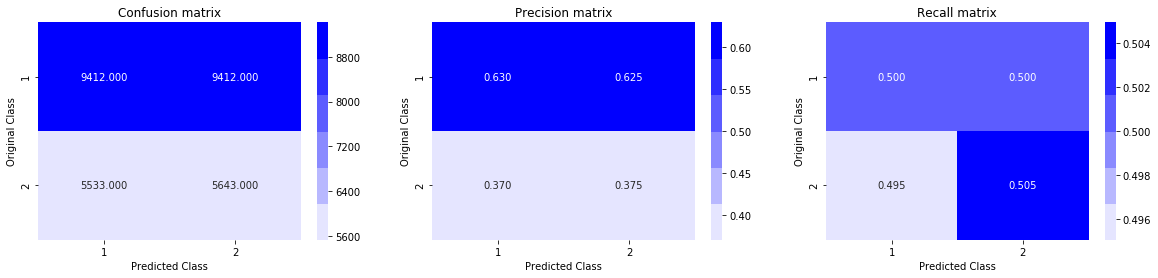

In [32]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns

# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# 2. Logistic Regression with hyperparameter tuning 

For values of alpha =  1e-07 The log loss is: 0.5444536402770691
For values of alpha =  1e-06 The log loss is: 0.45723470318226206
For values of alpha =  1e-05 The log loss is: 0.45689784437174735
For values of alpha =  0.0001 The log loss is: 0.4530547301601866
For values of alpha =  0.001 The log loss is: 0.4544997760893704
For values of alpha =  0.01 The log loss is: 0.4527832277742007
For values of alpha =  0.1 The log loss is: 0.4640191185484633
For values of alpha =  1 The log loss is: 0.4974880468195978
For values of alpha =  10 The log loss is: 0.5487480575692426


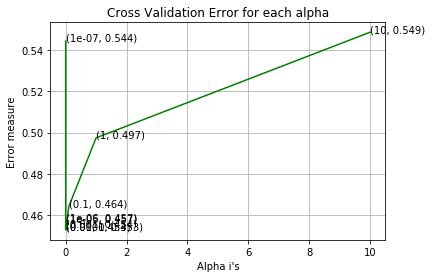

For values of best alpha =  0.01 The train log loss is: 0.4489321924305754
For values of best alpha =  0.01 The test log loss is: 0.4527832277742007
Total number of data points : 30000


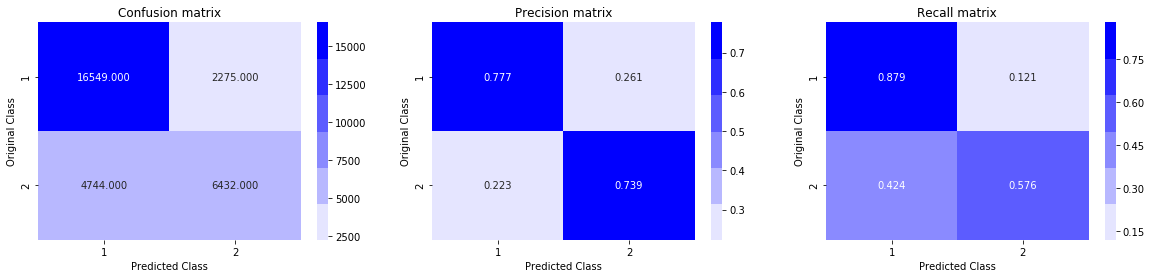

In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

alpha = [10 ** x for x in range(-7, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=21,n_jobs=6)
    clf.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=10)
    sig_clf.fit(X_train_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=21,n_jobs=6)
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=10)
sig_clf.fit(X_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 3. Linear SVM with hyperparameter tuning

For values of alpha =  1e-07 The log loss is: 0.6602902109101162
For values of alpha =  1e-06 The log loss is: 0.47834786827784703
For values of alpha =  1e-05 The log loss is: 0.48499215847332655
For values of alpha =  0.0001 The log loss is: 0.500989229303291
For values of alpha =  0.001 The log loss is: 0.5063629719533274
For values of alpha =  0.01 The log loss is: 0.5016216426348663
For values of alpha =  0.1 The log loss is: 0.49124196620156024
For values of alpha =  1 The log loss is: 0.5809162546897477
For values of alpha =  10 The log loss is: 0.6424070996764703


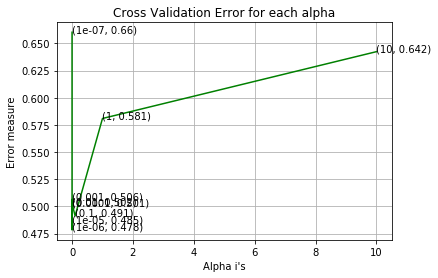

For values of best alpha =  1e-06 The train log loss is: 0.4524965417380067
For values of best alpha =  1e-06 The test log loss is: 0.45814612697644275
Total number of data points : 30000


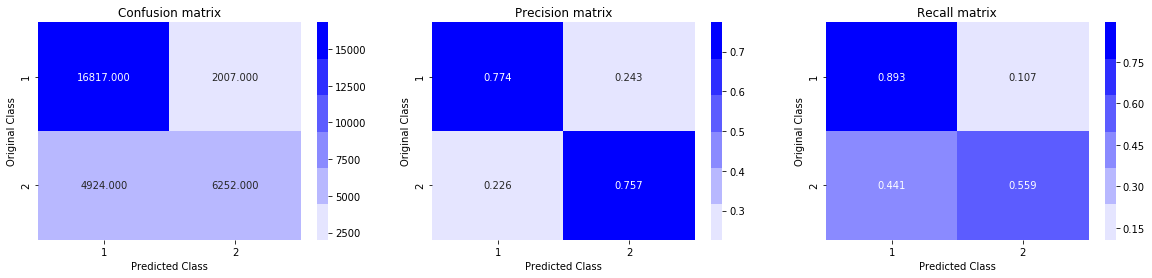

In [34]:
alpha = [10 ** x for x in range(-7, 2)]


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=21,n_jobs=6)
    clf.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidf, y_train)
    predict_y = sig_clf.predict_proba(X_test_tfidf)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=21,n_jobs=6)
clf.fit(X_train_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=10)
sig_clf.fit(X_train_tfidf, y_train)

predict_y = sig_clf.predict_proba(X_train_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# TFIDF-W2V (make own WORD VEC)



In [35]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model1 = TfidfVectorizer()
tfidf_model1.fit(X_train['preprocessed_q1'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model1.get_feature_names(), list(tfidf_model1.idf_)))
tfidf_words = set(tfidf_model1.get_feature_names())

In [36]:
list_preprocessed_q1_xtr = []
for e in X_train['preprocessed_q1'].values:
    list_preprocessed_q1_xtr.append(e.split())
    
from gensim.models import Word2Vec
preprocessed_q1_xtr=Word2Vec(list_preprocessed_q1_xtr,size=100,workers = 8)

In [37]:
# average Word2Vec
# compute average word2vec for Ques1 on train data
ques1_xtr_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_q1']): # for each review/sentence
    vector = np.zeros(100) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in list(preprocessed_q1_xtr.wv.vocab)) and (word in tfidf_words):
            vec = preprocessed_q1_xtr[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    ques1_xtr_tfidf_w2v_vectors.append(vector)

print(len(ques1_xtr_tfidf_w2v_vectors))
print(len(ques1_xtr_tfidf_w2v_vectors[0]))

100%|██████████| 70000/70000 [00:49<00:00, 1425.18it/s]


70000
100


In [38]:
# compute average word2vec for Ques1 on test data

ques1_xtest_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_q1']): # for each review/sentence
    vector = np.zeros(100) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in list(preprocessed_q1_xtr.wv.vocab)) and (word in tfidf_words):
            vec = preprocessed_q1_xtr[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    ques1_xtest_tfidf_w2v_vectors.append(vector)

print(len(ques1_xtest_tfidf_w2v_vectors))
print(len(ques1_xtest_tfidf_w2v_vectors[0]))

100%|██████████| 30000/30000 [00:21<00:00, 1418.95it/s]


30000
100


In [39]:
# Similarly you can vectorize for ques2 also
tfidf_model2 = TfidfVectorizer()
tfidf_model2.fit(X_train['preprocessed_q2'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model2.get_feature_names(), list(tfidf_model2.idf_)))
tfidf_words = set(tfidf_model2.get_feature_names())

In [40]:
list_preprocessed_q2_xtr = []
for e in X_train['preprocessed_q2'].values:
    list_preprocessed_q2_xtr.append(e.split())
    
preprocessed_q2_xtr_w2v=Word2Vec(list_preprocessed_q2_xtr,size=100,workers = 8)

In [41]:
q2_xtr_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_q2']): # for each review/sentence
    vector = np.zeros(100) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in list(preprocessed_q2_xtr_w2v.wv.vocab)) and (word in tfidf_words):
            vec = preprocessed_q2_xtr_w2v[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    q2_xtr_tfidf_w2v_vectors.append(vector)

print(len(q2_xtr_tfidf_w2v_vectors))
print(len(q2_xtr_tfidf_w2v_vectors[0]))

100%|██████████| 70000/70000 [00:47<00:00, 1459.74it/s]


70000
100


In [42]:
q2_xtest_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_q2']): # for each review/sentence
    vector = np.zeros(100) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in list(preprocessed_q2_xtr_w2v.wv.vocab)) and (word in tfidf_words):
            vec = preprocessed_q2_xtr_w2v[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    q2_xtest_tfidf_w2v_vectors.append(vector)

print(len(q2_xtest_tfidf_w2v_vectors))
print(len(q2_xtest_tfidf_w2v_vectors[0]))

100%|██████████| 30000/30000 [00:20<00:00, 1438.42it/s]


30000
100


In [43]:
# Merge TFIDF-W2v and all other tokenized features

X_train_tfidf_w2v = np.hstack((ques1_xtr_tfidf_w2v_vectors,q2_xtr_tfidf_w2v_vectors,X_train_idf.values))

X_test_tfidf_w2v = np.hstack((ques1_xtest_tfidf_w2v_vectors,q2_xtest_tfidf_w2v_vectors,X_test_idf.values))

print(X_train_tfidf_w2v.shape)
print(X_test_tfidf_w2v.shape)

(70000, 226)
(30000, 226)


# Train XGBoost on TFIDF-W2V  

In [46]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params={
 "max_depth"               : [ 3, 4, 5, 6, 8, 10, 12, 15,20],
 "min_child_weight"        : [ 1, 3, 5, 7 ,10],

  }
estimator1 = xgb.XGBClassifier(objective= 'binary:logistic',
eval_metric= 'logloss',scale_pos_weight = 1,random_state=123)
Rsearch1= RandomizedSearchCV(estimator1,param_distributions=params,scoring='roc_auc',n_jobs=6,iid=False, cv=10,verbose=21,random_state=123)
Rsearch1.fit(X_train_tfidf_w2v,y_train)
Rsearch1.best_params_, Rsearch1.best_score_


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  5.5min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  5.6min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  9.0min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  9.0min
[Parallel(

({'min_child_weight': 5, 'max_depth': 10}, 0.9242843782278228)

In [44]:
w=Rsearch1.best_params_["min_child_weight"]
d=Rsearch1.best_params_['max_depth']

In [47]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params={

 "colsample_bytree"        : [0.3, 0.4, 0.5 , 0.7 ,0.9],
 'subsample'               :[0.75,0.80,0.85,0.90],
 
  }
estimator2 =xgb.XGBClassifier(objective= 'binary:logistic',
eval_metric= 'logloss',scale_pos_weight = 1,random_state=21,min_child_weight = w,max_depth = d)
Rsearch2= RandomizedSearchCV(estimator2,param_distributions=params,scoring='roc_auc',n_jobs=-1,iid=False, cv=10,verbose=21,random_state=21)
Rsearch2.fit(X_train_tfidf_w2v,y_train)
Rsearch2.best_params_, Rsearch2.best_score_


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 1

({'subsample': 0.9, 'colsample_bytree': 0.9}, 0.9250906938843195)

In [48]:
c=Rsearch2.best_params_["colsample_bytree"]
s=Rsearch2.best_params_['subsample']

In [59]:
# train Final Xgboost model using all tunned hyperParameters

import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = d

params['min_child_weight'] = w
params['colsample_bytree'] = c
params['subsample'] = s    



d_train = xgb.DMatrix(X_train_tfidf_w2v, label=y_train)
d_test = xgb.DMatrix(X_test_tfidf_w2v, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train_tfidf_w2v,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.682486	valid-logloss:0.683074
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.594782	valid-logloss:0.600993
[20]	train-logloss:0.531191	valid-logloss:0.542417
[30]	train-logloss:0.482881	valid-logloss:0.498788
[40]	train-logloss:0.445504	valid-logloss:0.465788
[50]	train-logloss:0.415647	valid-logloss:0.440021
[60]	train-logloss:0.39147	valid-logloss:0.419743
[70]	train-logloss:0.371594	valid-logloss:0.403776
[80]	train-logloss:0.355208	valid-logloss:0.390919
[90]	train-logloss:0.341171	valid-logloss:0.380444
[100]	train-logloss:0.329731	valid-logloss:0.372023
[110]	train-logloss:0.319742	valid-logloss:0.365103
[120]	train-logloss:0.31147	valid-logloss:0.35959
[130]	train-logloss:0.304286	valid-logloss:0.354969
[140]	train-logloss:0.297939	valid-logloss:0.351038
[150]	train-logloss:0.292017	valid-logloss:0.347675
[160]	train-logloss:0.286927	va

Total number of data points : 30000


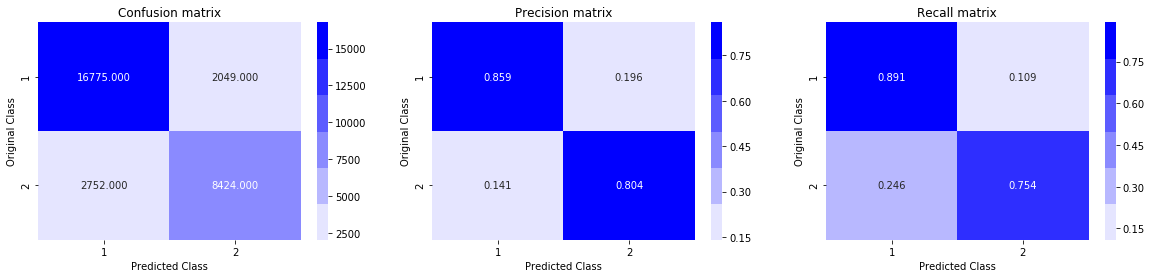

In [60]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)